In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score, rand_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

## VADE

In [3]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
class Encoder(layers.Layer):

    def __init__(self, latent_dim=10, intermediate_dims=[64, 128, 64], name="encoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.hidden_layers = []
        for intermediate_dim in intermediate_dims:
            self.hidden_layers.append(layers.Dense(intermediate_dim, activation="relu"))
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


In [5]:
class Decoder(layers.Layer):

    def __init__(self, original_dim, intermediate_dims=[64, 128, 64], name="decoder", **kwargs):
        super().__init__(name=name, **kwargs)
        self.hidden_layers = []
        for intermediate_dim in intermediate_dims:
            self.hidden_layers.append(layers.Dense(intermediate_dim, activation="relu"))
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.dense_output(x)

In [66]:
class VADE(Model):

    def __init__(
        self,
        original_dim,
        intermediate_dims=[64, 128, 64],
        latent_dim=10,
        n_clusters=10,
        name="vade",
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.n_clusters = n_clusters

        self.train_loss_tracker = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")

        self.val_mi_tracker = tf.keras.metrics.Mean(name="val_mutual_info_score")

        self.val_rand_tracker = tf.keras.metrics.Mean(name="val_rand_score")

        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dims=intermediate_dims)
        self.decoder = Decoder(original_dim, intermediate_dims=intermediate_dims)

        self.pi = self.add_weight(
            name="pi",
            shape=(self.n_clusters,),
            initializer=tf.keras.initializers.Constant(1.0 / self.n_clusters),
            trainable=True,
        )
        self.mu = self.add_weight(
            name="mu",
            shape=(self.n_clusters, self.latent_dim),
            initializer="zeros",
            trainable=True,
        )
        self.sigma = self.add_weight(
            name="sigma",
            shape=(self.n_clusters, self.latent_dim),
            initializer="ones",
            trainable=True,
        )


    def prob_z_c(self, z):
        Z = tf.tile(tf.expand_dims(z, 1), [1, self.n_clusters, 1])
        MU = tf.tile(tf.expand_dims(self.mu, 0), [tf.shape(z)[0], 1, 1])
        SIGMA = tf.tile(tf.expand_dims(self.sigma, 0), [tf.shape(z)[0], 1, 1])

        return 1e-10+(2 * np.pi) ** (-self.latent_dim / 2) / tf.reduce_prod(SIGMA, axis=2) * tf.exp(-tf.reduce_sum((Z-MU) * tf.math.reciprocal(SIGMA) * (Z-MU), axis=2) / 2)

    def gamma_c(self, z):
        PI = tf.tile(tf.expand_dims(self.pi, 0), [tf.shape(z)[0], 1])
        prob_z_c = self.prob_z_c(z)
        denom = tf.reduce_sum(PI * prob_z_c, axis=1, keepdims=True)
        return PI * prob_z_c / denom

    def predict_c_x(self, x):
        _, _, z = self.encoder(x, training=False)
        probs = self.gamma_c(z)
        preds = tf.argmax(probs, axis=1)
        return preds

    def predict_c_z(self, z):
        probs = self.gamma_c(z)
        preds = tf.argmax(probs, axis=1)
        return preds

    def calculate_loss(self, x, x_decoded_mean, z_mean, z_log_var, z):

        part1 = binary_crossentropy(x, x_decoded_mean) * self.original_dim # batch_size x 1

        Z_log_var = tf.tile(tf.expand_dims(z_log_var, 1), [1, self.n_clusters, 1]) # batch_size x n_clusters x latent_dim
        Z_mean = tf.tile(tf.expand_dims(z_mean, 1), [1, self.n_clusters, 1])
        gamma = self.gamma_c(z) # batch_size x n_clusters

        MU = tf.tile(tf.expand_dims(self.mu, 0), [tf.shape(z)[0], 1, 1]) # batch_size X n_cluster x latent_dim
        SIGMA = tf.tile(tf.expand_dims(self.sigma, 0), [tf.shape(z)[0], 1, 1])
        part2a = 2*tf.math.log(SIGMA)
        part2b = tf.exp(Z_log_var) / SIGMA ** 2
        part2c = (Z_mean-MU) ** 2 / SIGMA ** 2
        part2 = 0.5 * tf.reduce_sum(gamma * tf.reduce_sum(part2a + part2b + part2c, axis=2), axis=1) # batch_size x 1

        PI = tf.tile(tf.expand_dims(self.pi, 0), [tf.shape(z)[0], 1]) # batch_size x n_clusters
        part3 = -tf.reduce_sum(gamma * tf.math.log(PI / gamma), axis=1) # batch_size x 1

        part4 = -0.5 * (latent_dim + tf.reduce_sum(z_log_var, axis=1))

        return tf.reduce_mean(part1+part2+part3+part4)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        x_decoded_mean = self.decoder(z)
        return x_decoded_mean, z_mean, z_log_var, z

    def train_step(self, x):
        with tf.GradientTape() as tape:
            x_decoded, z_mean, z_log_var, z = self(x)

            loss = self.calculate_loss(x, x_decoded, z_mean, z_log_var, z)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.train_loss_tracker.update_state(loss)

        return {"loss": self.train_loss_tracker.result()}

    def test_step(self, data):
        x,y = data
        x_decoded, z_mean, z_log_var, z = self(x, training=False)

        val_loss = self.calculate_loss(x, x_decoded, z_mean, z_log_var, z)
        self.val_loss_tracker.update_state(val_loss)

        return {"loss": val_loss}

## VAE

In [67]:

class VAE(Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dims=[64, 128, 64],
        latent_dim=10,
        name="autoencoder",
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dims=intermediate_dims)
        self.decoder = Decoder(original_dim, intermediate_dims=intermediate_dims)
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")

    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        x_decoded = self.decoder(z)
        return x_decoded, z_mean, z_log_var

    def train_step(self, x):
        with tf.GradientTape() as tape:
            x_decoded, z_mean, z_log_var = self(x)

            kl = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            loss = binary_crossentropy(x, x_decoded) * self.original_dim + kl
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss)
        return {"loss": self.total_loss_tracker.result()}

    def test_step(self, x):
        x_decoded, z_mean, z_log_var = self(x)
        kl = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        val_loss = binary_crossentropy(x, x_decoded) * self.original_dim + kl
        val_loss = tf.reduce_mean(val_loss)
        self.val_loss_tracker.update_state(val_loss)
        return {"loss": val_loss}

## Data

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype("float32") / 255
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype("float32") / 255


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Pretraining VADE

In [9]:
original_dim = 784
hidden_dims = [512,512,2048]
latent_dim = 10

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

epochs = 3

In [10]:
vae = VAE(original_dim, hidden_dims, latent_dim)
vae.compile(optimizer=optimizer)
history = vae.fit(x_train, epochs=epochs, batch_size=128)

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - loss: 187.4499
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 97.9521
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 90.0920


In [11]:
z_test_pred = vae.encoder(x_test)
test_pred = vae.decoder(z_test_pred[2])

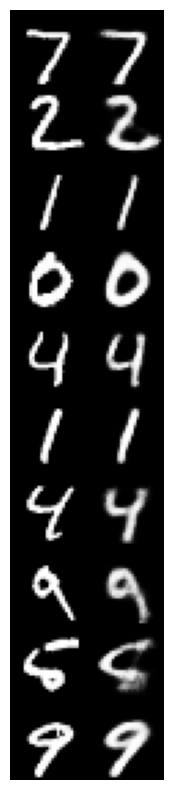

In [12]:
n = 10
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred.numpy()

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## Weights transfer

In [13]:
def weights_transfer(vade, vae, x_train, n_clusters=10):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='diag')
    _,_,z = vae.encoder(x_train)
    gmm.fit(z.numpy())

    #vade.pi.assign(tf.constant(gmm.weights_))
    vade.mu.assign(tf.constant(gmm.means_))
    vade.sigma.assign(tf.constant(gmm.covariances_))

    vade(x_train) # initialize the weights

    vae_weights = {layer.name: layer.get_weights() for layer in vae.layers}

    for layer in vade.layers:
        if layer.name in vae_weights:
            layer.set_weights(vae_weights[layer.name])

## Train VADE


In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vade = VADE(original_dim, hidden_dims, latent_dim, n_clusters=10)
vade.compile(optimizer=optimizer)
weights_transfer(vade, vae, x_train)

In [15]:
class ClustScoresCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict_c_x(self.x_test)
        r_score = rand_score(self.y_test, y_pred)
        mi_score = normalized_mutual_info_score(self.y_test, y_pred)

        logs['val_rand_score'] = r_score
        logs['val_mi_score'] = mi_score

In [16]:
epochs = 200
c_scores_callback = ClustScoresCallback(x_test, y_test)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model_weights.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=0
)

hist = vade.fit(x_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=128, callbacks=[c_scores_callback, checkpoint_callback])

Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 108.7168 - val_loss: 98.1620 - val_rand_score: 0.9172 - val_mi_score: 0.6467
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 103.8295 - val_loss: 98.2073 - val_rand_score: 0.9192 - val_mi_score: 0.6596
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 101.9104 - val_loss: 94.9614 - val_rand_score: 0.9199 - val_mi_score: 0.6636
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 100.3275 - val_loss: 92.6164 - val_rand_score: 0.9215 - val_mi_score: 0.6691
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 99.2358 - val_loss: 91.6623 - val_rand_score: 0.9220 - val_mi_score: 0.6772
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 98.2288 - val_loss: 92.4575 - val_rand_score: 0.9229 - val_mi_score: 0.6779
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 97.4383 - val_loss: 89.8768 - val_rand_score: 0.9237 - val_mi_score: 0.6858
Epoch 8/200
469/469 ━━━━━━━━━━━━━━━

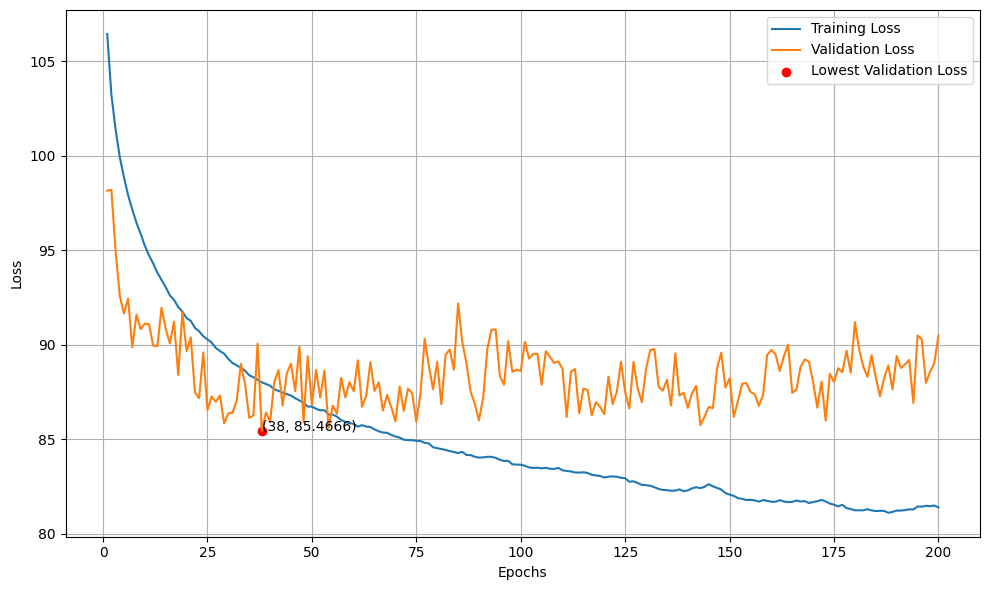

In [17]:
val_loss = hist.history["val_loss"]
loss = hist.history["loss"]

min_val_loss_epoch = val_loss.index(min(val_loss))

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')

plt.scatter(min_val_loss_epoch + 1, val_loss[min_val_loss_epoch], color='red', label='Lowest Validation Loss')
plt.text(min_val_loss_epoch + 1, val_loss[min_val_loss_epoch], f'({min_val_loss_epoch + 1}, {val_loss[min_val_loss_epoch]:.4f})')


plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vade_loss.png")
plt.show()

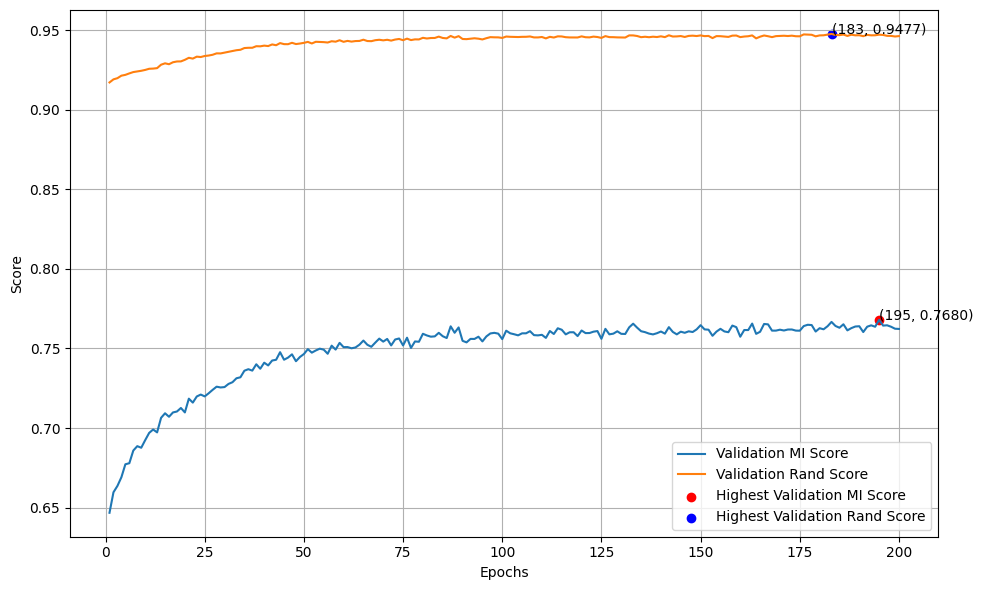

In [18]:
val_mi_score = hist.history["val_mi_score"]
val_rand_score = hist.history["val_rand_score"]

max_val_mi_score_epoch = val_mi_score.index(max(val_mi_score))

max_val_rand_score_epoch = val_rand_score.index(max(val_rand_score))

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_mi_score, label='Validation MI Score')
plt.plot(range(1, epochs + 1), val_rand_score, label='Validation Rand Score')

plt.scatter(max_val_mi_score_epoch + 1, val_mi_score[max_val_mi_score_epoch], color='red', label='Highest Validation MI Score')
plt.text(max_val_mi_score_epoch + 1, val_mi_score[max_val_mi_score_epoch], f'({max_val_mi_score_epoch + 1}, {val_mi_score[max_val_mi_score_epoch]:.4f})')

plt.scatter(max_val_rand_score_epoch + 1, val_rand_score[max_val_rand_score_epoch], color='blue', label='Highest Validation Rand Score')
plt.text(max_val_rand_score_epoch + 1, val_rand_score[max_val_rand_score_epoch], f'({max_val_rand_score_epoch + 1}, {val_rand_score[max_val_rand_score_epoch]:.4f})')

plt.xlabel('Epochs')
plt.ylabel('Score')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vade_scores.png")
plt.show()

In [19]:
vade.load_weights("best_model_weights.weights.h5")

In [20]:
z_test_pred = vade.encoder(x_test)
test_pred = vade.decoder(z_test_pred[2])

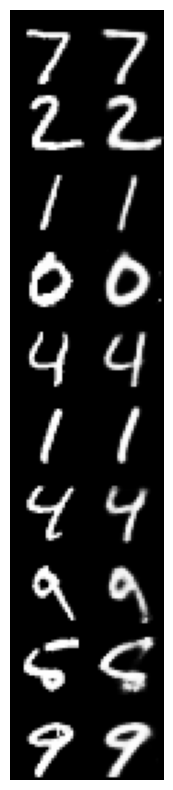

In [21]:
n = 10
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred.numpy()

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## VAE training

In [22]:
original_dim = 784
hidden_dims = [512,512,2048]
latent_dim = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
epochs = 200

In [23]:
checkpoint_callback_vae = tf.keras.callbacks.ModelCheckpoint(
    filepath="vae.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=0
)

In [24]:
vae = VAE(original_dim, hidden_dims, latent_dim)
vae.compile(optimizer=optimizer)
history = vae.fit(x_train, validation_data=x_test, epochs=epochs, batch_size=128, callbacks=[checkpoint_callback_vae])

Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 189.3533 - val_loss: 95.8400
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 99.3186 - val_loss: 83.0605
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 90.2638 - val_loss: 82.0434
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 86.4791 - val_loss: 79.7243
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 84.2073 - val_loss: 77.6685
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 82.4093 - val_loss: 77.4098
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 81.3034 - val_loss: 77.7878
Epoch 8/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 80.2414 - val_loss: 76.1518
Epoch 9/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 79.4303 - val_loss: 76.3319
Epoch 10/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 78.7589 - val_loss: 75.2715
Epoch 11/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 78.2262 - val_loss: 73.4693
Epoch 12/200
469

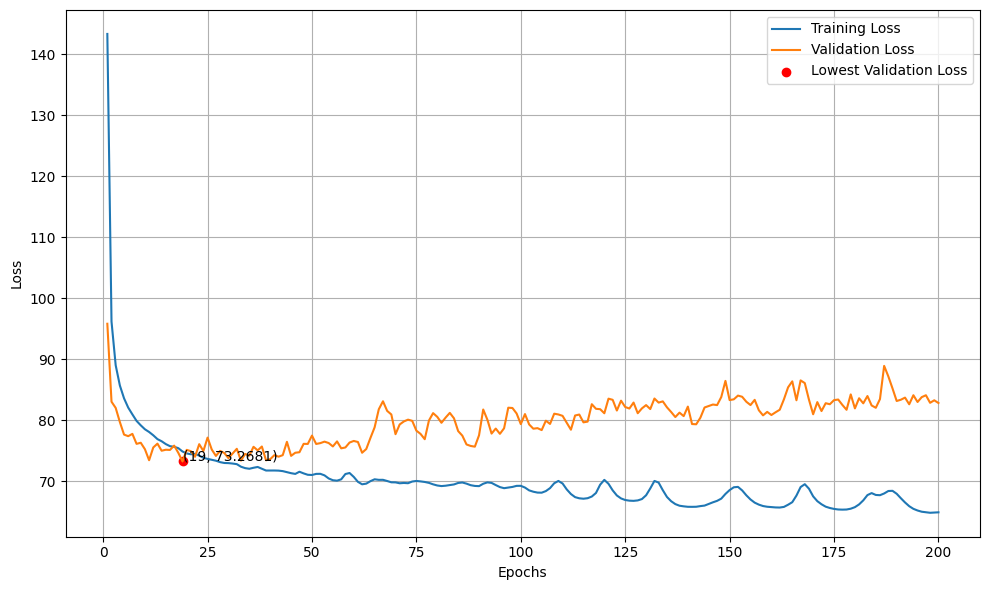

In [25]:
val_loss = history.history["val_loss"]
loss = history.history["loss"]

min_val_loss_epoch = val_loss.index(min(val_loss))

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')

plt.scatter(min_val_loss_epoch + 1, val_loss[min_val_loss_epoch], color='red', label='Lowest Validation Loss')
plt.text(min_val_loss_epoch + 1, val_loss[min_val_loss_epoch], f'({min_val_loss_epoch + 1}, {val_loss[min_val_loss_epoch]:.4f})')


plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vae_loss.png")
plt.show()

In [26]:
vae.load_weights("vae.weights.h5")

## Comparison of clustering in latent space

In [27]:
_, _, z_test_vae = vae.encoder(x_test, training=False)
_, _, z_test_vade = vade.encoder(x_test, training=False)

tsne_vae = TSNE(n_components=2)
tsne_vade = TSNE(n_components=2)

z_test_vae_tsne = tsne_vae.fit_transform(z_test_vae)
z_test_vade_tsne = tsne_vade.fit_transform(z_test_vade)

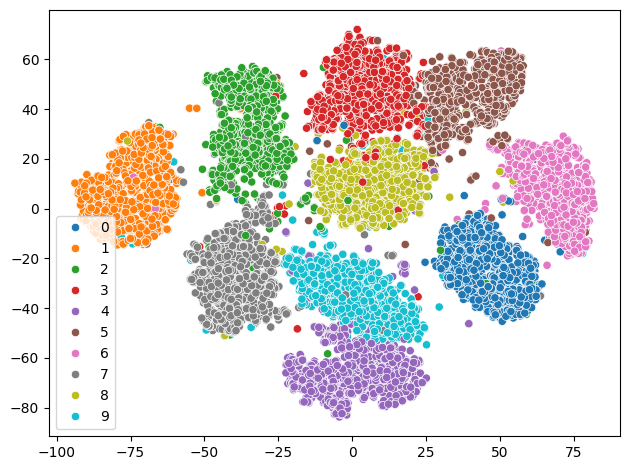

In [28]:
sns.scatterplot(x=z_test_vae_tsne[:,0], y=z_test_vae_tsne[:,1], hue=y_test, palette=sns.color_palette("tab10"))
plt.tight_layout()
plt.savefig("vae_latent.png")
plt.show()

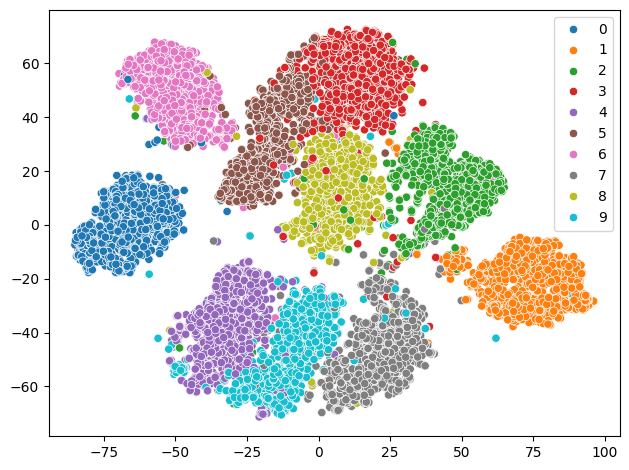

In [29]:
sns.scatterplot(x=z_test_vade_tsne[:,0], y=z_test_vade_tsne[:,1], hue=y_test, palette=sns.color_palette("tab10"))
plt.tight_layout()
plt.savefig("vade_latent.png")
plt.show()

In [30]:
vae_sil_score = silhouette_score(z_test_vae, y_test)
vade_sil_score = silhouette_score(z_test_vade, y_test)

vae_ch_score = calinski_harabasz_score(z_test_vae, y_test)
vade_ch_score = calinski_harabasz_score(z_test_vade, y_test)

print(f"VAE Silhouette Score: {vae_sil_score}")
print(f"VADE Silhouette Score: {vade_sil_score}")
print(f"VAE Calinski Harabasz Score: {vae_ch_score}")
print(f"VADE Calinski Harabasz Score: {vade_ch_score}")

VAE Silhouette Score: 0.10964547097682953
VADE Silhouette Score: 0.15859484672546387
VAE Calinski Harabasz Score: 646.9044949542312
VADE Calinski Harabasz Score: 1169.1197964335859


## Generating new observations

In [50]:
new_digits = np.zeros((100, original_dim))
for i in range(10):
    sigma = vade.sigma[i].numpy()
    cov = np.diag(sigma**2)
    mu = vade.mu[i].numpy()
    latent = np.random.multivariate_normal(mu, cov, 10)
    new_digits[i*10:(i+1)*10,:] = vade.decoder(latent).numpy()

In [53]:
new_digits_ordered = np.zeros((100, original_dim))
switch_order = [1, 9, 8, 4, 0, 7, 6, 2, 3, 5]
for i in range(10):
    for j in range(10):
        new_digits_ordered[i*10+j,:] = new_digits[switch_order[i]*10+j,:]

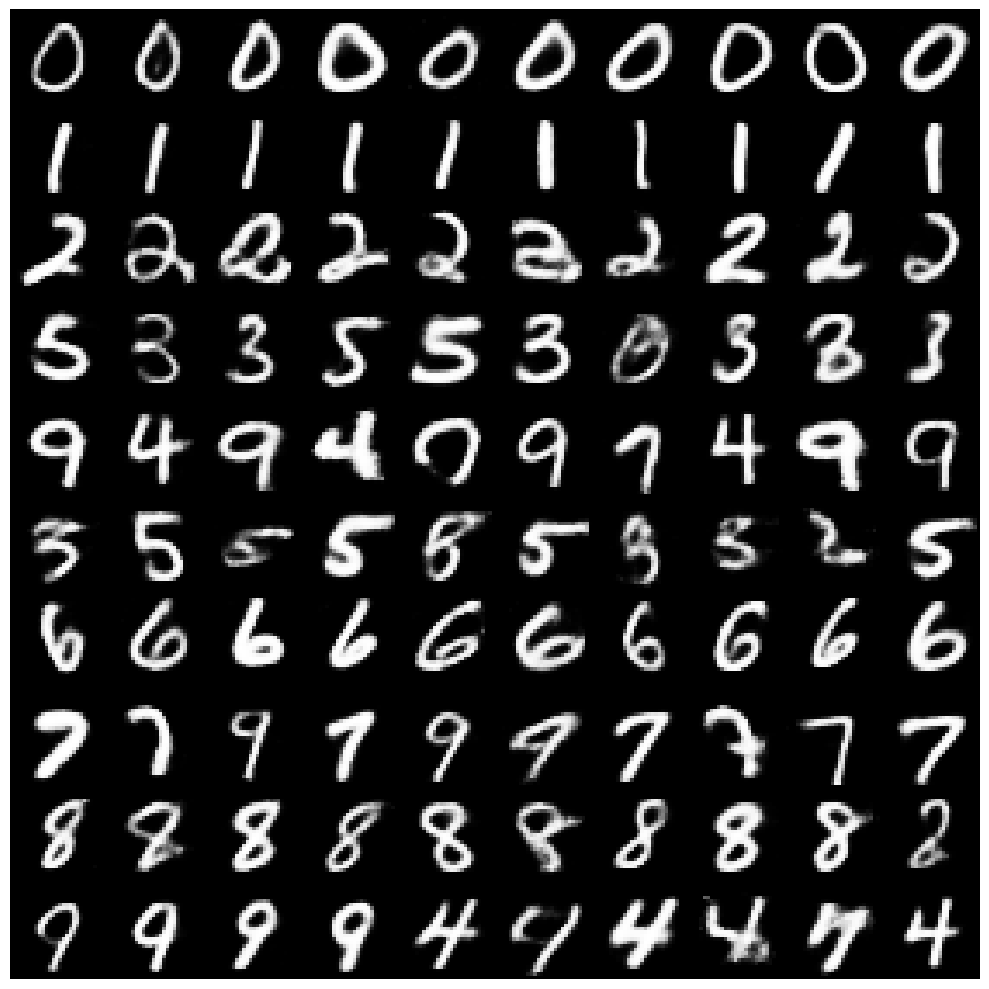

In [54]:


digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * 10, digit_size * 10))

for i in range(10):
    for j in range(10):
        figure[i * digit_size: (i + 1) * digit_size, j*digit_size:(j+1)*digit_size] = new_digits_ordered[i*10+j, :].reshape(digit_size, digit_size)


plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()
plt.savefig("new_digits.png")
plt.show()

In [55]:
results = np.zeros((10,10))
for c in range(10):
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(x_train[y_train==c], y_train[y_train==c])
    for i in range(10):
        for j in range(10):
            results[i,c] += knn.kneighbors(new_digits_ordered[i*10+j,:].reshape(1,-1))[0][0,0]
results /= 10

In [59]:
results /=  np.max(results)

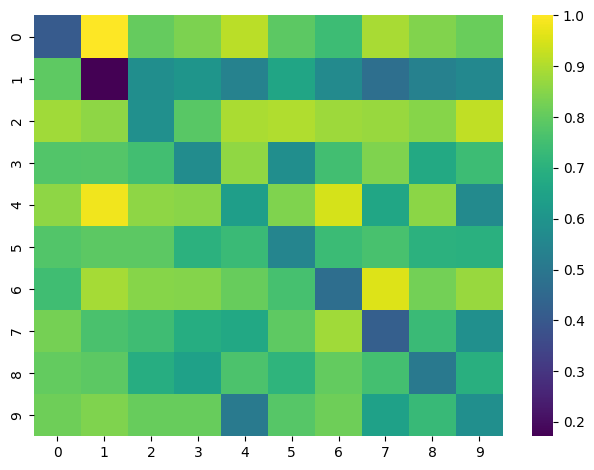

In [62]:
sns.heatmap(results, cmap='viridis')
plt.tight_layout()
plt.savefig("heatmap.png")
plt.show()